In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv(r"C:\Study\Bicycle Traffic\Data Excel\samplebicycledata.csv")
# Group the data by 'ID' and collect 'heartrate' for each group
grouped = df.groupby('ID')['power']

# Concatenate the heartrate series into a DataFrame, aligning by index
power_df = pd.concat([group.reset_index(drop=True) for _, group in grouped], axis=1)

# Set the column names to the rider IDs
power_df.columns = [rider_id for rider_id, _ in grouped]

In [3]:
import numpy as np
import pandas as pd
from scipy.interpolate import PchipInterpolator
from scipy.ndimage import gaussian_filter1d

# Function to apply PCHIP interpolation and Gaussian smoothing to a single series,
# excluding NaN values at the end of the trip
def apply_pchip_and_gaussian(series, sigma=2):
    # Limit to first 600 intervals
    series = series.iloc[:1000]
    
    # Drop trailing NaNs (end of the ride)
    series = series[:series.last_valid_index() + 1]
    
    # Drop remaining NaNs for interpolation
    not_nan = ~series.isna()
    if not np.any(not_nan):
        return series  # Return if all values are NaN
    
    x = np.arange(len(series))
    y = series[not_nan]

    # PCHIP interpolation
    pchip_interpolator = PchipInterpolator(x[not_nan], y)
    y_interp = pchip_interpolator(x)
    
    # Apply Gaussian smoothing
    y_smoothed = gaussian_filter1d(y_interp, sigma=sigma)
    
    # Reinsert the trailing NaNs
    y_smoothed = np.concatenate([y_smoothed, np.full(len(series.index) - len(y_smoothed), np.nan)])
    
    return pd.Series(y_smoothed, index=series.index)

# Apply the function to each column in the DataFrame for the first 600 intervals
smoothed_power_df = power_df.apply(lambda col: apply_pchip_and_gaussian(col, sigma=2))

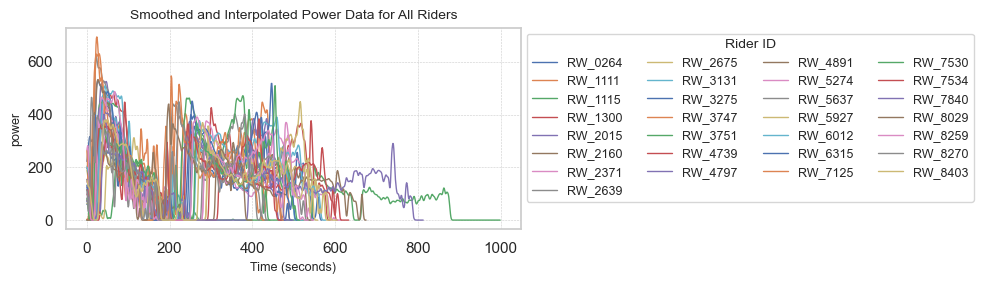

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up Seaborn for enhanced visual style
sns.set(style="whitegrid")

# Define the figure size
plt.figure(figsize=(10, 3))

# Plot each rider's smoothed heart rate data with distinct colors
for rider_id in smoothed_power_df.columns:
    plt.plot(smoothed_power_df.index, smoothed_power_df[rider_id], label=rider_id, linewidth=1)

# Add labels and title with professional formatting
plt.xlabel('Time (seconds)', fontsize=9)
plt.ylabel('power', fontsize=9)
plt.title('Smoothed and Interpolated Power Data for All Riders', fontsize=10)

# Add a legend outside the plot for better readability
plt.legend(title='Rider ID', title_fontsize=10, fontsize=9, bbox_to_anchor=(1, 1), loc='upper left', ncol=4)


# Adjust the ticks for better readability
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Add gridlines with professional styling
plt.grid(True, which='both', linestyle='--', linewidth=0.4)

# Ensure the layout is tight and the plot doesn't overlap
plt.tight_layout()

# Save the figure as a high-resolution image suitable for a thesis
plt.savefig('smoothed_heart_rate_thesis.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()